# Synthesized Observations

We can employ the Maria software to generate synthetic mock observations of bolometric arrays mounted on large single-dish telescopes. We developed a wrapper known as "Simulation," which emulates telescopes such as ACT, Toltec, GBT, and AtLAST. The wrapper produces time-ordered domain (TOD) data. By simulating distinct atmospheric layers that correspond to the designated site within the simulation, we enable the mock-array to sweep across the actual celestial sky while encountering varying atmospheric conditions in between. Consequently, the TODs produced will be a composite of the genuine sky, atmospheric effects, and detector noise (based on the white noise measurements of ACT). Through this approach, the process of generating mock-observations also yields filtered observations, effectively dampening the sensitivity to larger scales due to the atmospheric interferences.

This tutorial will explain you how to setup the simulation tool an make your own mock-observations.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [2]:
from maria import Simulation
from maria import mappers

## Set up the Simulation
The "Simulation" class offers the flexibility to incorporate various inputs tailored to atmospheric simulations. For instance, it allows the creation of an observatory like 'AtLAST,' situated at the APEX site. Similarly, if the intention is to simulate Mustang-2 observations but, for instance, under less favorable weather conditions, adjusting the 'quantiles' parameter within the Simulation keywords can achieve this.

Furthermore, the Simulation class accommodates the exploration of how different scanning strategies affect the filtering of large scales. Standard strategies, such as the back-and-forth or Daisy scan patterns, have been implemented for this purpose. This feature enables the study of how the chosen scanning approach influences the overall large-scale filtering.

For comprehensive documentation regarding all available keywords, we recommend consulting the detailed documentation provided at [insert documentation reference]. Now, let's proceed to initiate an example of a mock observation involving a significant galaxy cluster merger event at redshift 1 observed via the SZ effect, utilizing the Mustang-2 instrument:

### Initialize
First we need to initialize the telescope and weather conditions

In [3]:
sim = Simulation(

    # Mandatory minimal weither settings
    # ---------------------
    array     = 'MUSTANG-2',       # Array type
    pointing  = 'DAISY-2deg',      # Scanning strategy 
    site      = 'GBT',             # Site
    atm_model = 'linear_angular',  # The atmospheric model, set to None if you want a noiseless observation.
    # atm_model = None,              # The atmospheric model, set to None if you want a noiseless observation.
    
    # True sky input
    # ---------------------
    map_file     = "../../../maps/protocluster.fits",                     # Input files must be a fits file.
                                                                          # map_file can also be set to None if are only interested in the noise
    # map_file     = None,                     # Input files must be a fits file.
                                                                          # map_file can also be set to None if are only interested in the noise

    map_center   = (4.5, 10),                                             # RA & Dec in degree

    # Defeault Observational setup
    # ----------------------------
    integration_time = 600,          # seconds
    scan_center      = (4.5, 10),    # degrees
    pointing_frame   = "ra_dec",     # frame
    scan_radius      = 0.05,         # How large the scanning pattern is in degree

    # Additional inputs:
    # ----------------------
    quantiles    = {'column_water_vapor' : 0.5},    # Weather conditions specific for that site
    map_units    = 'Jy/pixel',                      # Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel 
    map_inbright = -2e-9,                        # Linearly scale the map to have this peak value.
    map_res      = 0.1 / 1000,                      # degree, overwrites header information
)   


Computing weights: 100%|██████████| 4/4 [00:00<00:00, 137.18it/s]


### Get the TODs
To get the time ordered domain (TOD) data you simply need to run the script. The tod is an object which has the time, and coordinates stored together with the intensity of each scan per detector. The units of the intensities are always outputted in surface brightness temperature units: Kelvin Rayleigh Jeans.

In [4]:
tod = sim.run()

Sampling layers: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


### Usefull visualizations:
We first need to adjust the input sky as specified in the Simulation class above

In [5]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

# - Input figure
inputfile =  "../../../maps/protocluster.fits"
hdu = fits.open(inputfile)

hdu[0].data = hdu[0].data * -2e-9/np.nanmax(hdu[0].data) 
header = hdu[0].header
header['CDELT1'] = 0.1 / 1000 # degree
header['CDELT2'] = 0.1 / 1000 # degree

header['CRVAL1'] = (4.5, 10)[0] 
header['CRVAL2'] = (4.5, 10)[1] 
wcs_input = WCS(header, naxis = 2)  

Now let's visualize the scanning strategy and the TOD data

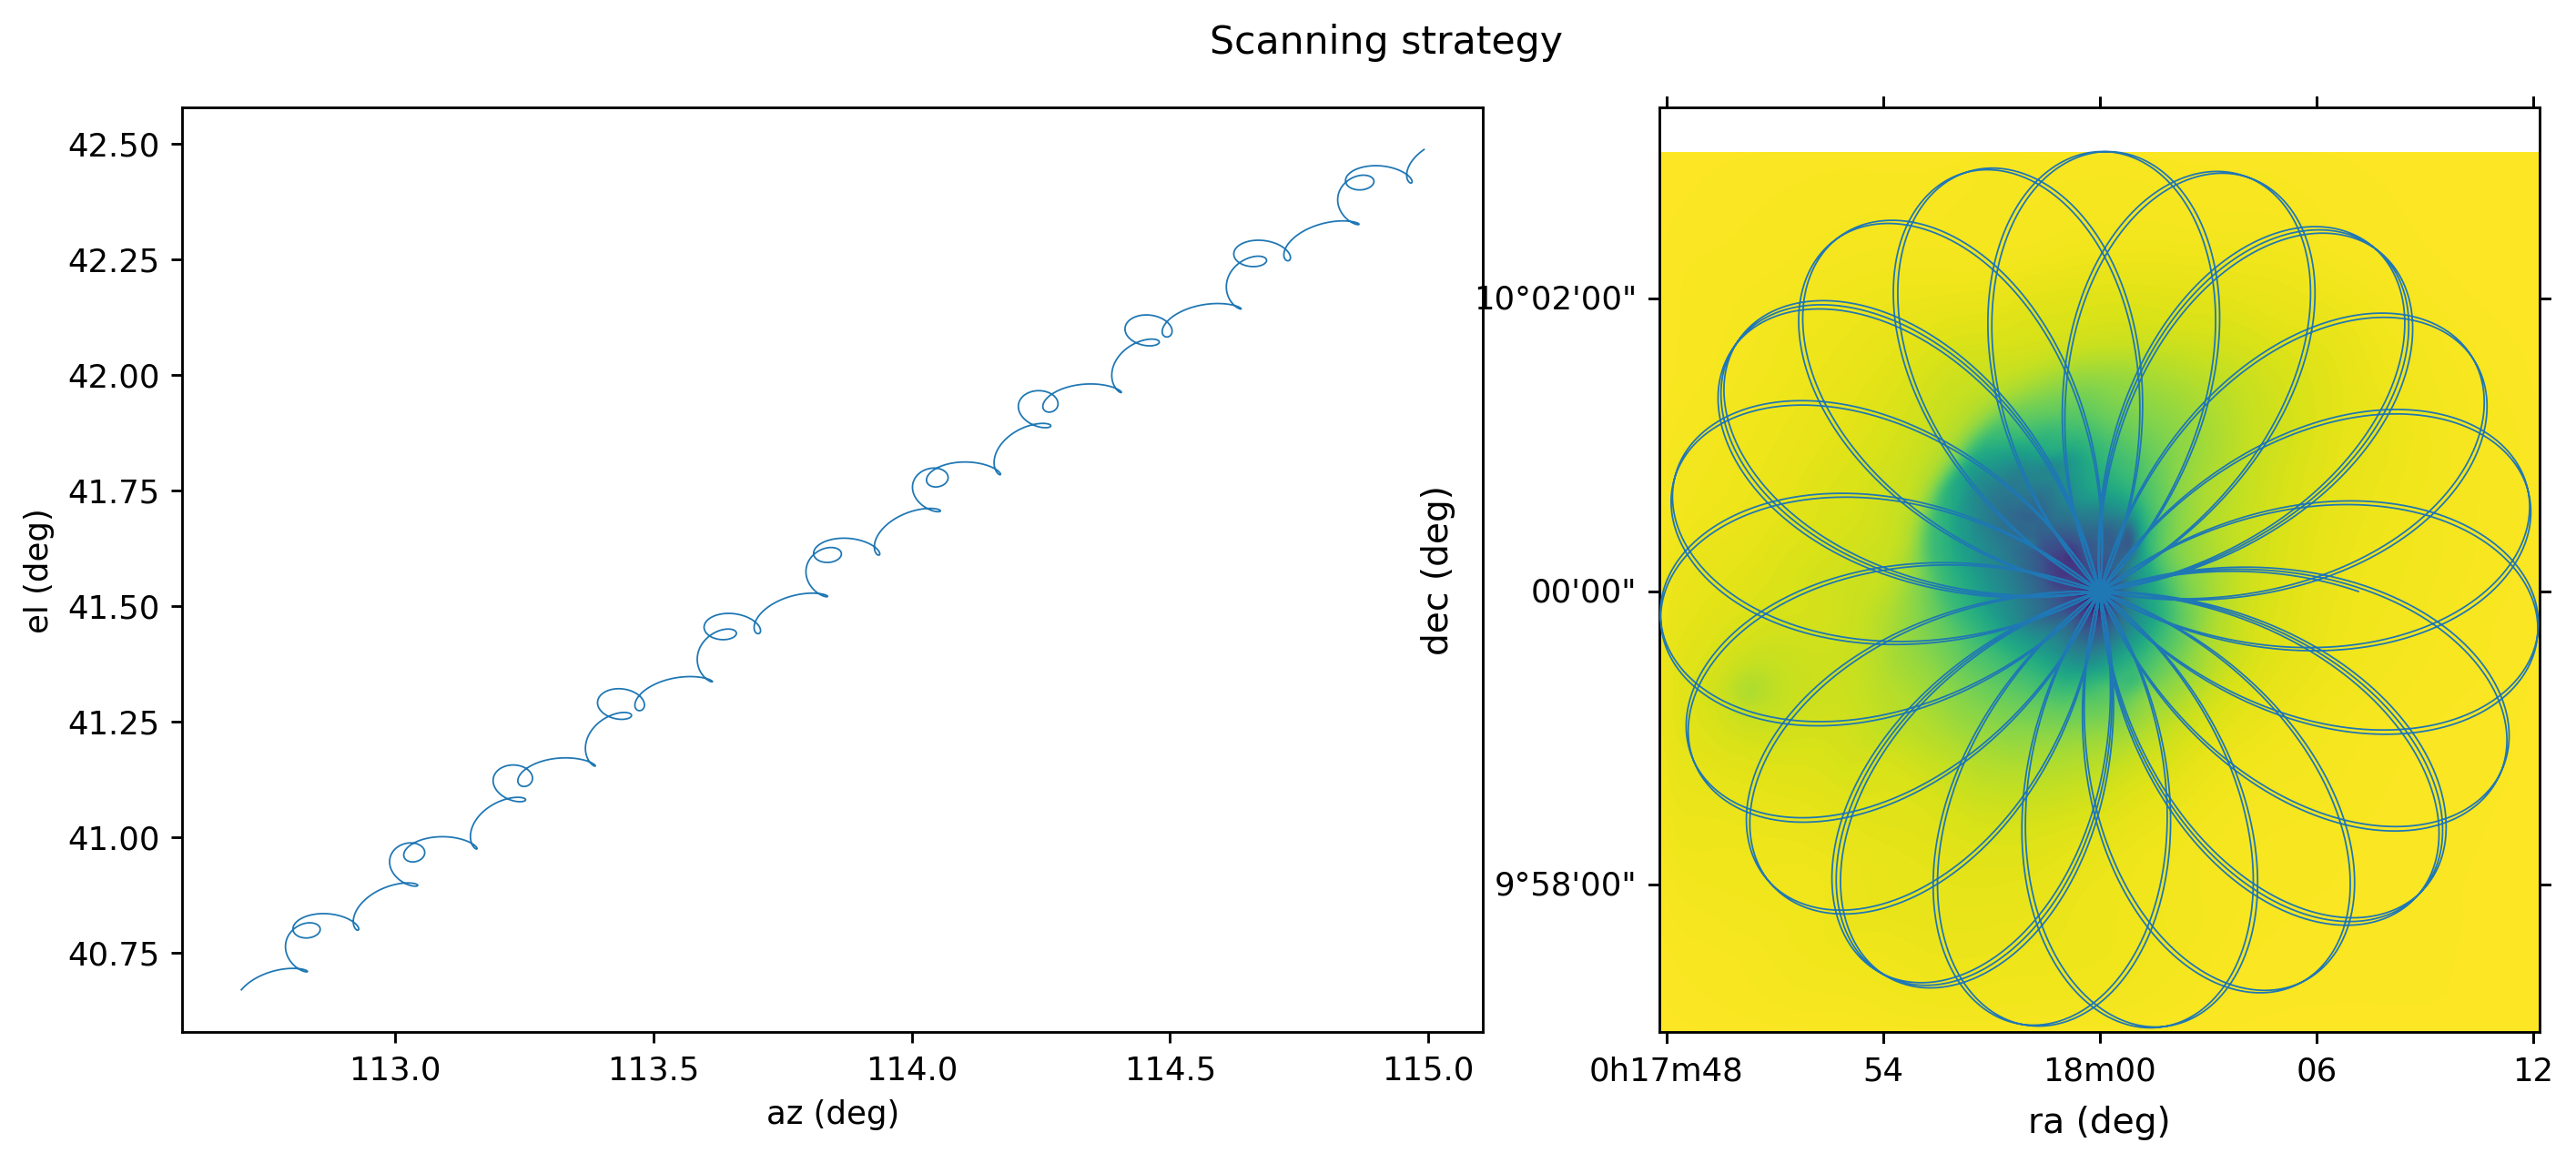

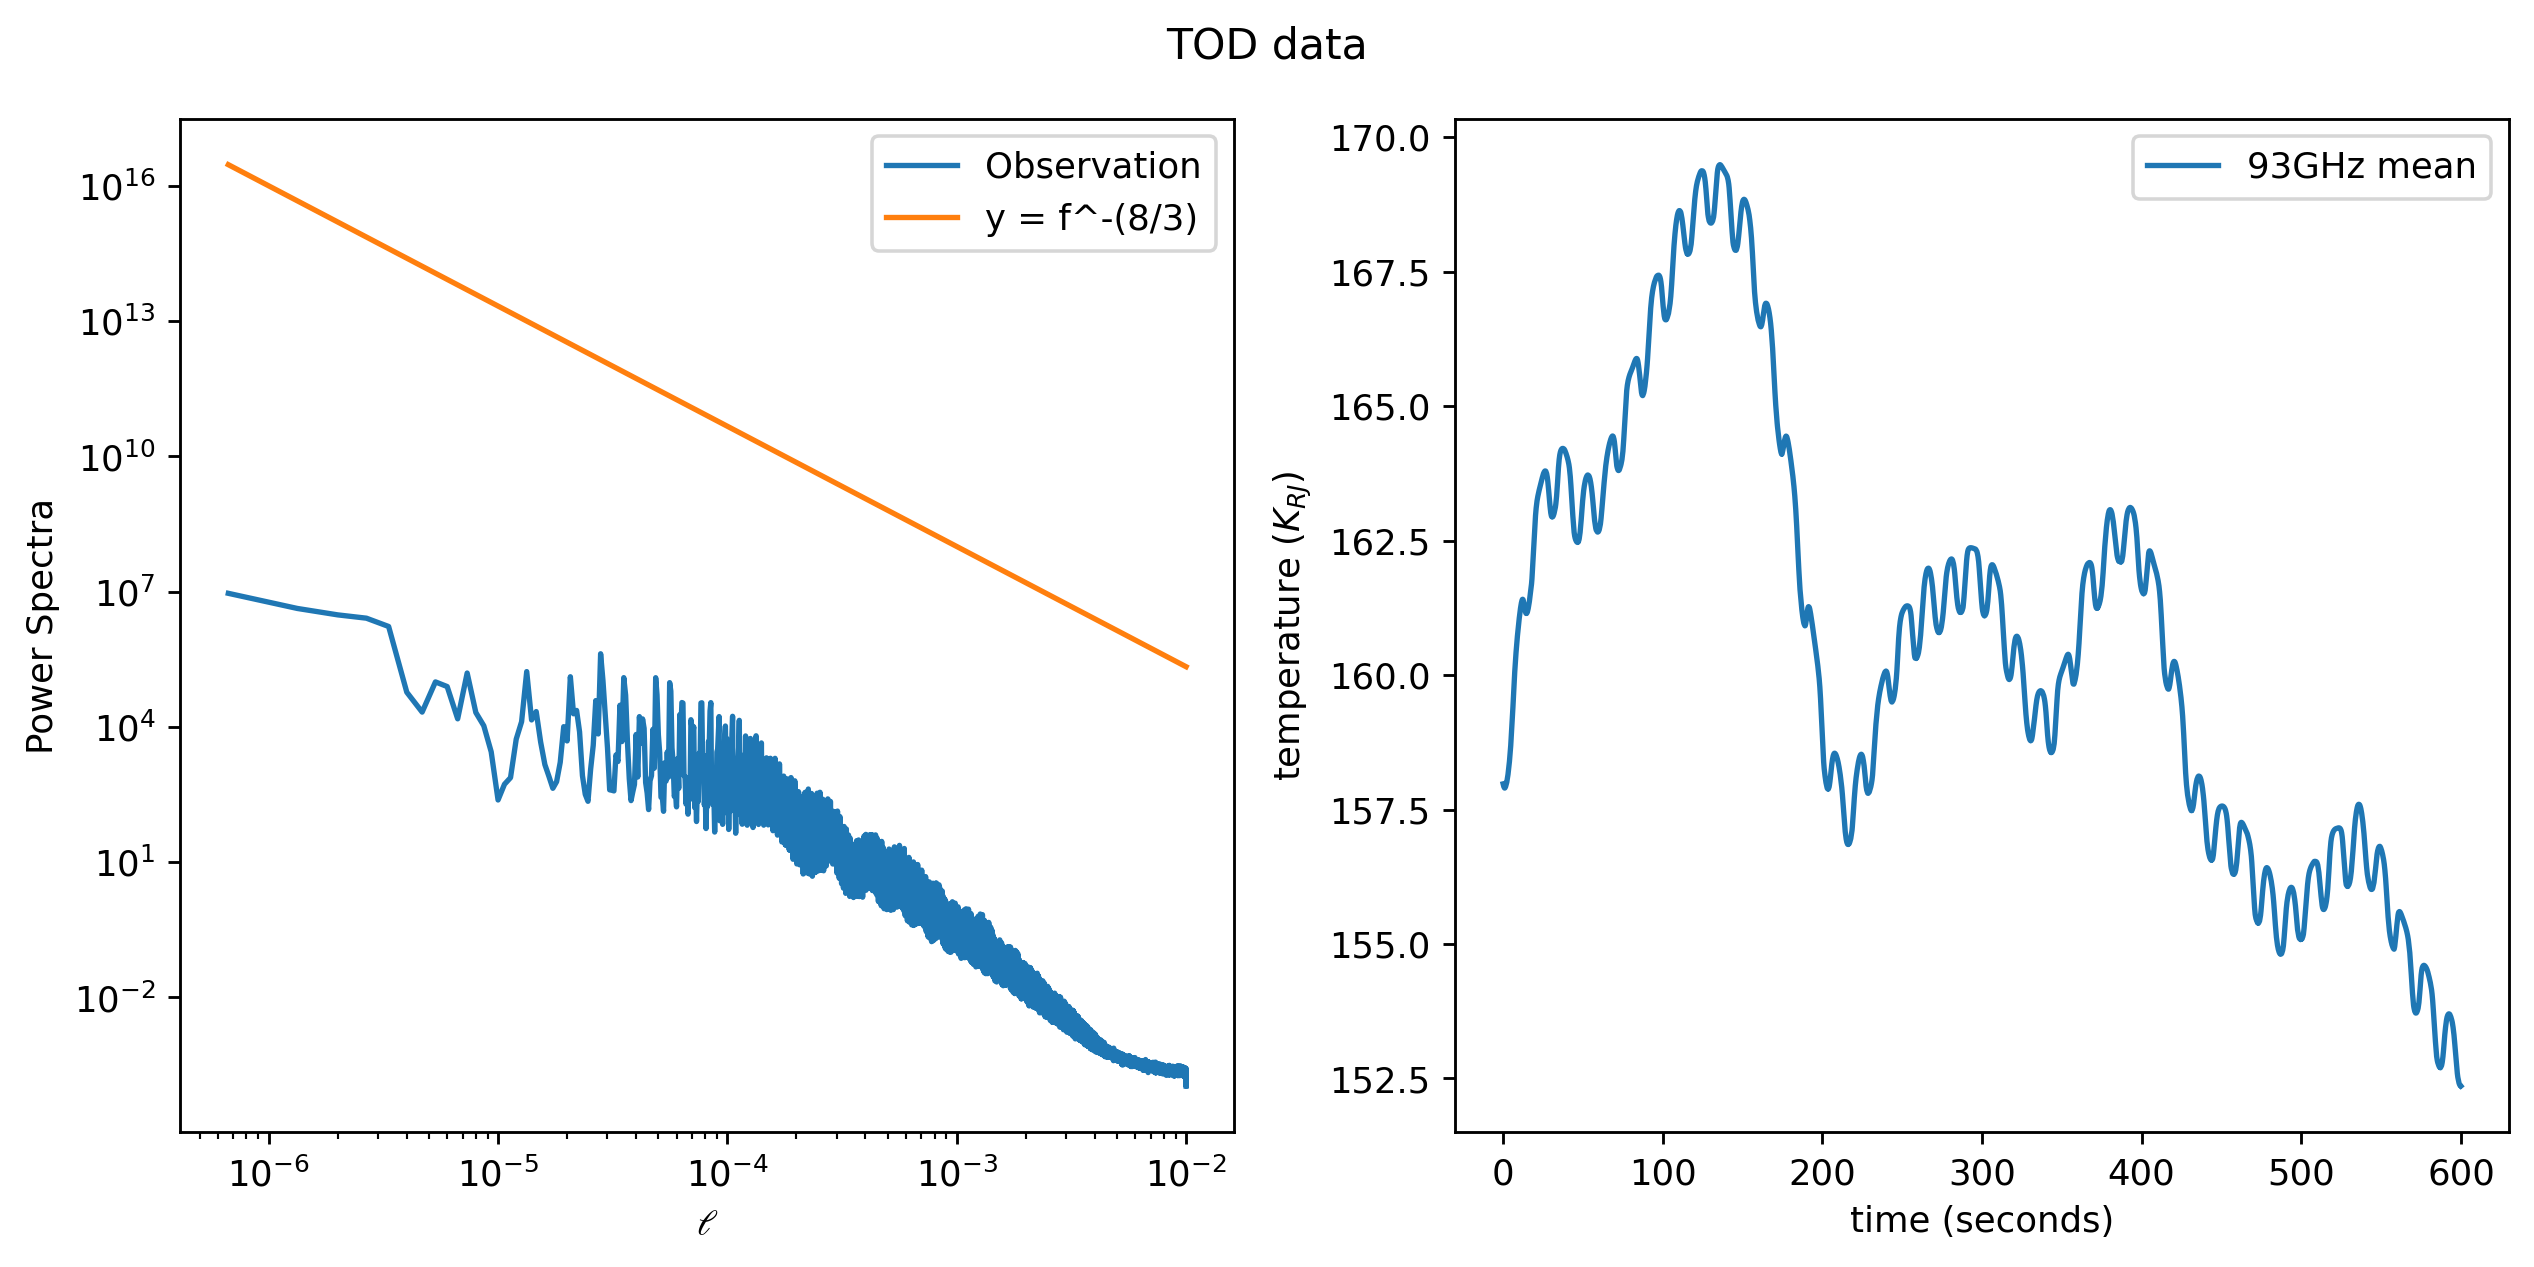

In [6]:
# visualize scanning patern
# -----------------------
fig = plt.figure(dpi = 256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle('Scanning strategy')

# - Plot
ax = plt.subplot(1,2,1,)

ax.plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1,2,2, projection=wcs_input)
im = ax.imshow(hdu[0].data)

ra, dec = ax.coords
ra.set_major_formatter('hh:mm:ss')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.ra)*u.deg, np.degrees(tod.dec)*u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1]-tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle('TOD data')
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f'{uband} mean')

axes[1].set_xlabel('time (seconds)'), axes[1].set_ylabel(r'temperature ($K_{RJ}$)')
axes[1].legend()

plt.show()

## Mapping the TODs
To create images from the TODs, you'll need a mapper. While you can develop your own mapper using the saved TODs, we've also included a pre-implemented option for your convenience. This built-in mapper follows a straightforward approach: it combines data into bins, removes the first eigenmode, and arranges the data on a grid. Notably, the mapper is designed to effectively eliminate correlated atmospheric noise present among different scans, thereby enhancing the quality of the resulting images.

An example of running a mapper on the tod works as follows:

In [7]:
mapper = mappers.BinMapper(map_height=np.radians(10/60),
                           map_width=np.radians(10/60),
                           map_res=np.radians(0.4/1000))
mapper.add_tods(tod)
mapper.run()

The mapper uses the Array information specificied above. Below you can find the detector positions in the plane of the sky. Then, the figure next to it, shows how many time a detector passed a certain pixel on the map which is related to the sensitivity of map and the scanning strategy specialized above. 

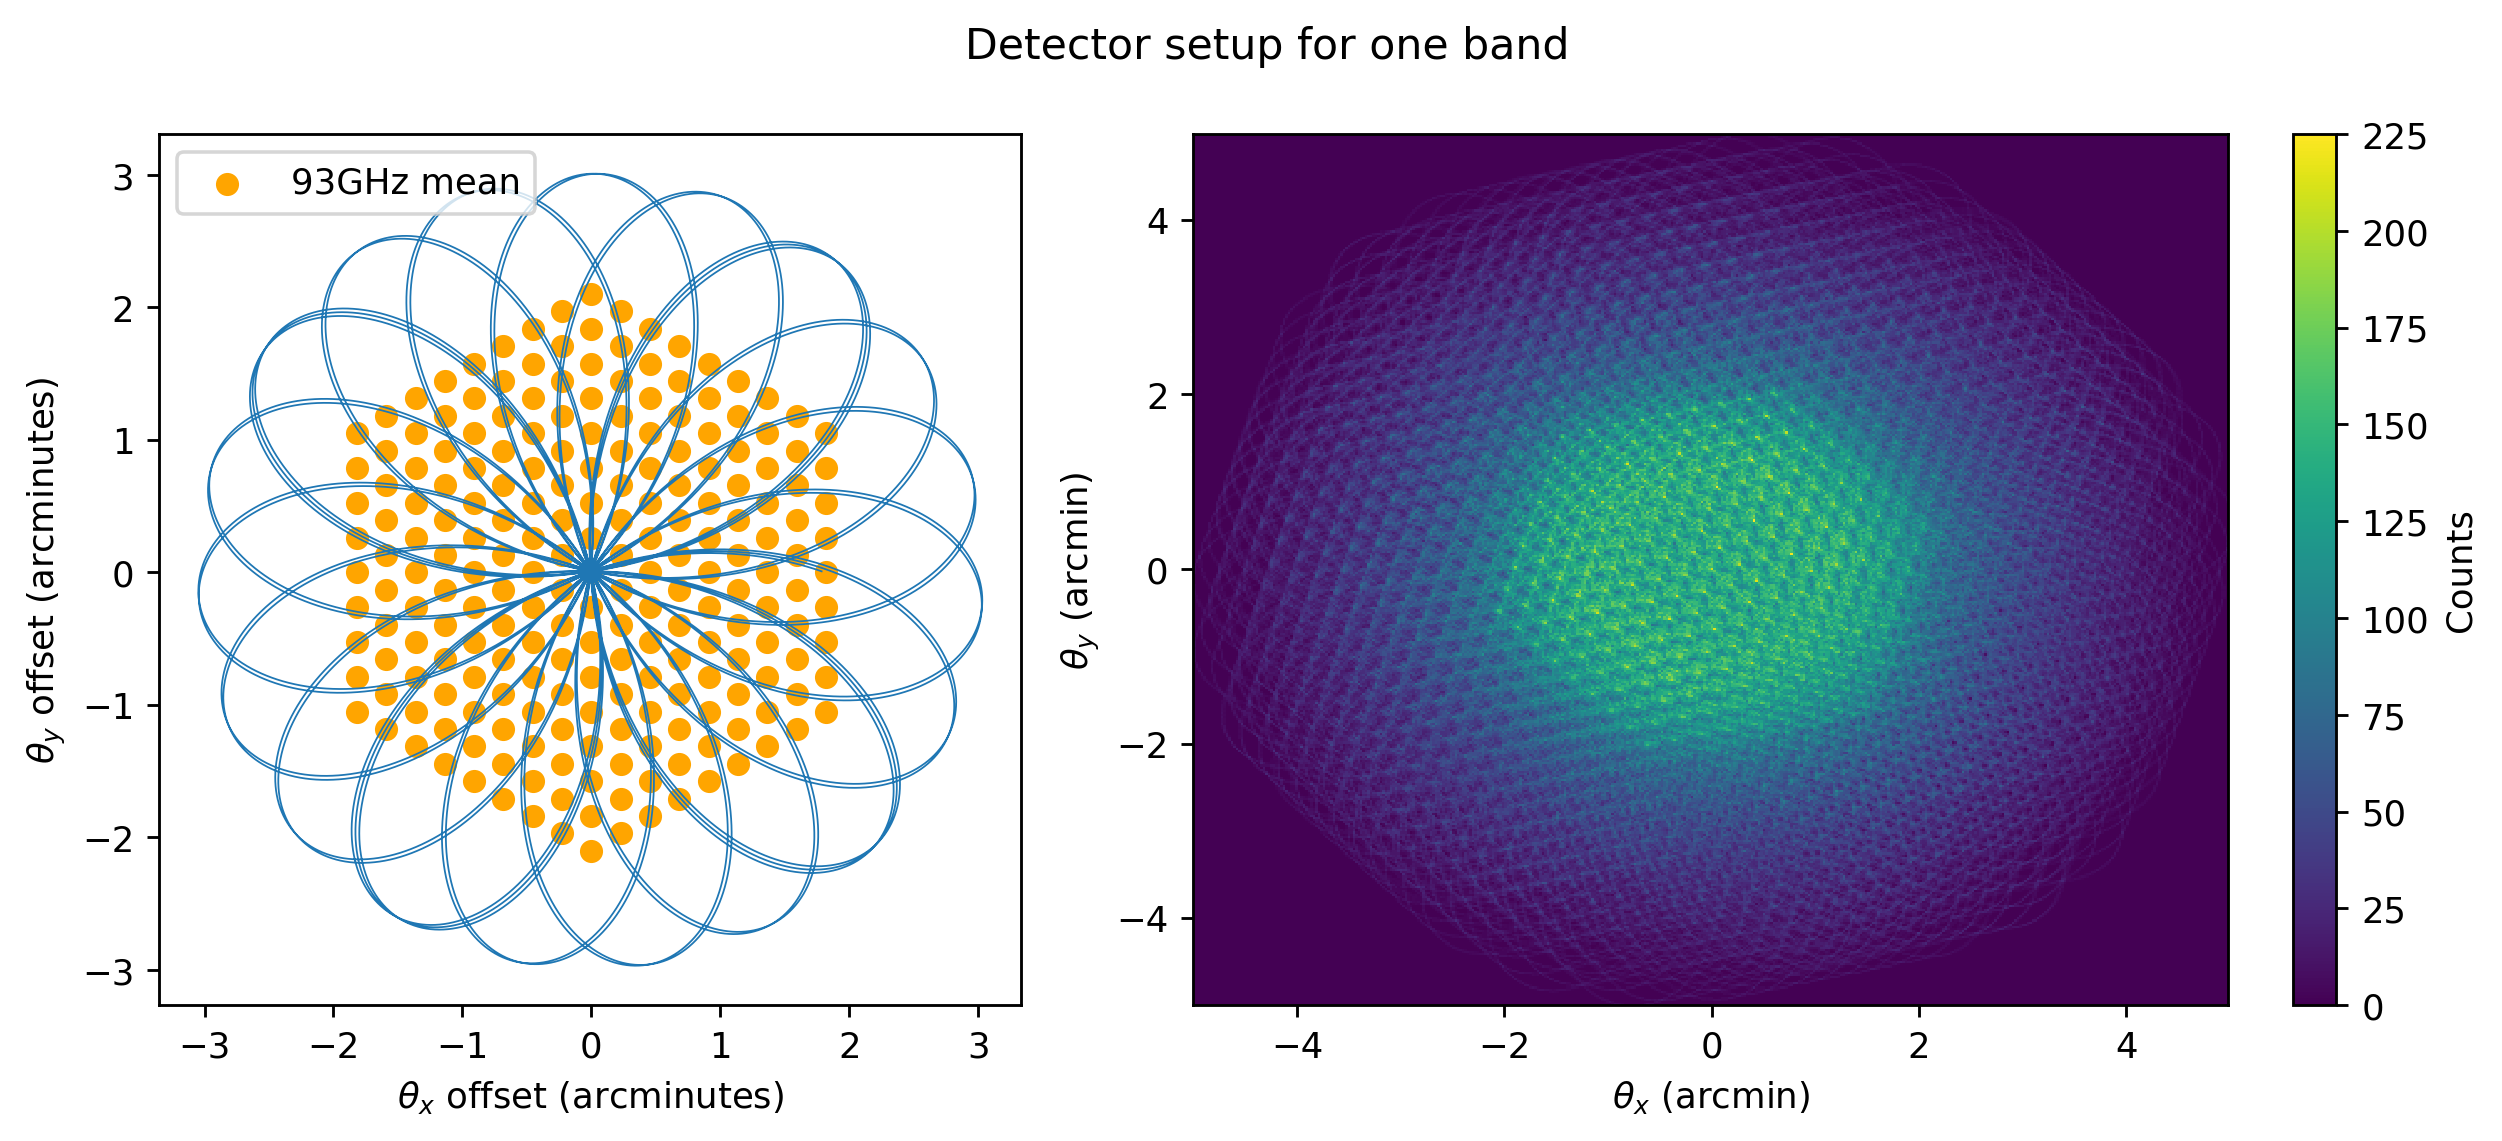

In [8]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1,1.5]})
fig.suptitle('Detector setup for one band')

for uband in sim.array.ubands:

    band_mask = sim.array.dets.band == uband

    axes[0].plot(60*np.degrees(tod.ra-tod.ra.mean()), 60*np.degrees(tod.dec-tod.dec.mean()), lw=5e-1)    
    axes[0].scatter(60 * np.degrees(sim.array.sky_x[band_mask]), 
                    60 * np.degrees(sim.array.sky_y[band_mask]),
                    label=f'{uband} mean', lw=5e-1, c = 'orange')
    break
axes[0].set_xlabel(r'$\theta_x$ offset (arcminutes)'), axes[0].set_ylabel(r'$\theta_y$ offset (arcminutes)')
axes[0].legend()

xs, ys = np.meshgrid(60*np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1])/2),
                     60*np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1])/2))
       
im = axes[1].pcolormesh(
                   xs, 
                   ys, 
                   mapper.map_cnts[tod.dets.band[0]], 
                   label = 'Photon counts in band '+ tod.dets.band[0])

axes[1].set_xlabel(r'$\theta_x$ (arcmin)'), axes[1].set_ylabel(r'$\theta_y$ (arcmin)')
cbar = plt.colorbar(im, ax = axes[1])
cbar.set_label('Counts')
plt.show()

# Visualzing the maps
As interesting as the detector setup, power spectra, and time series are, the goal of this module is to create synthetic observations. Here, we will take you through how to retrieve the scientific data and measure the noise properties of the observations. 

First, we can save the maps to fits files, simply by running ```mapper.save()```. This will output the fits and update the header according to the newly set observations.

In [9]:
mapper.save_maps("/tmp/test.fits")

Let's show what we got. On the left we show the input map which we adjusted a in the Simulation class. Therefore, we need to adjust the header of the input map too.

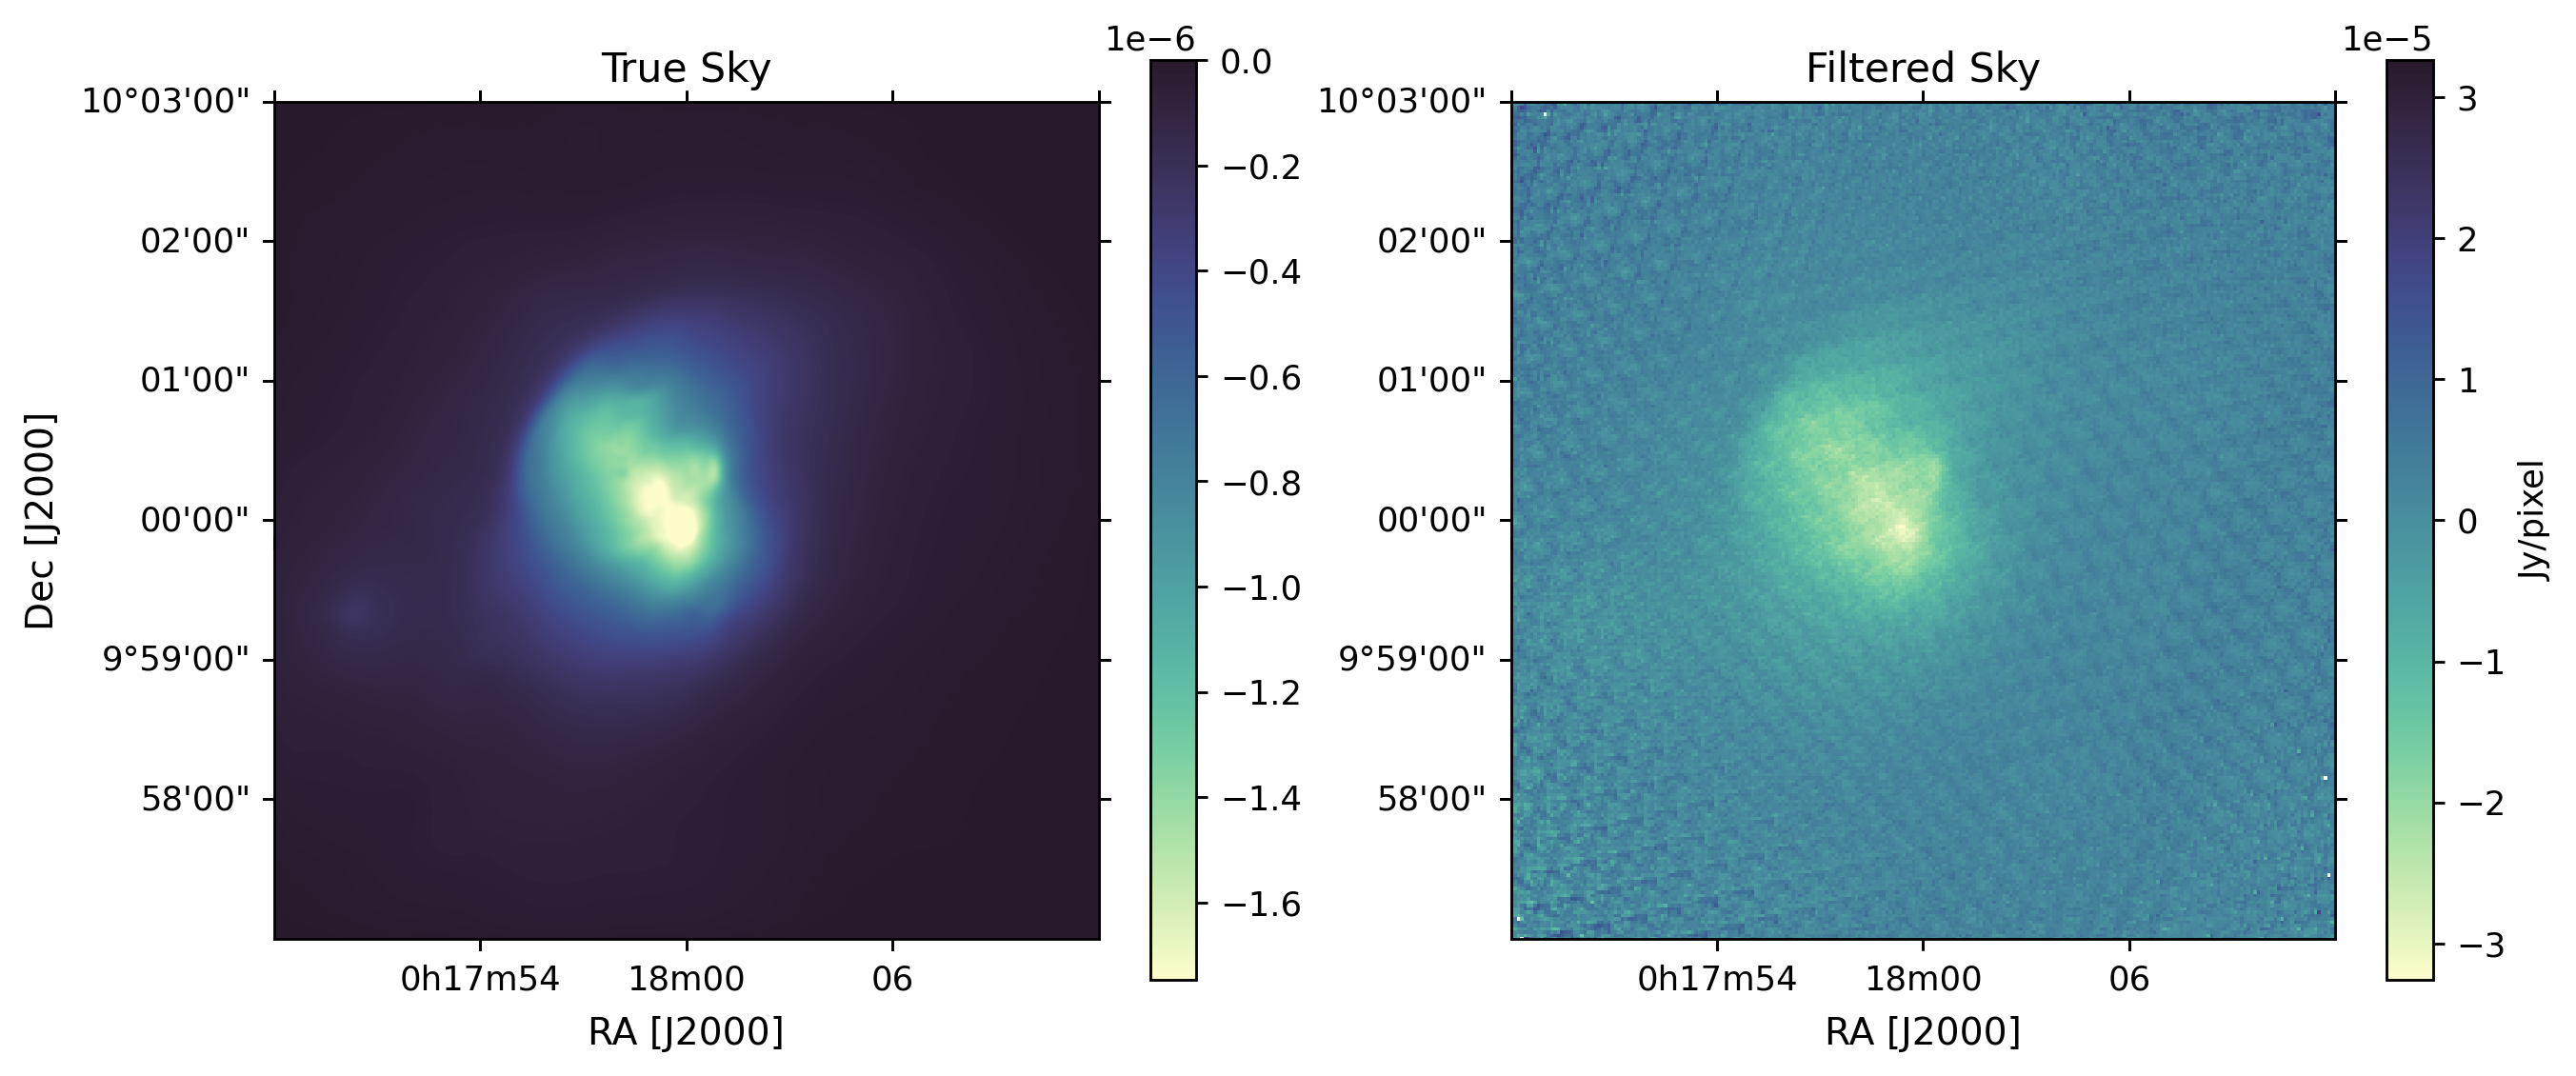

In [12]:
import cmocean

fig = plt.figure(dpi = 256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

vmax = 0
vmin = np.nanmin(hdu[0].data)/1.2

# - Plot
ax = plt.subplot(1,2,1, projection=wcs_input)
ax.set_title('True Sky')
im = ax.imshow(hdu[0].data, vmin = vmin, vmax = vmax, cmap = cmocean.cm.deep)
cbar = plt.colorbar(im, ax = ax, shrink = 1.)

ra, dec = ax.coords
ra.set_major_formatter('hh:mm:ss')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky_l = SkyCoord((4.5-3/60)*u.deg, (10-3/60.)*u.deg)
sky_u = SkyCoord((4.5+3/60)*u.deg, (10+3/60.)*u.deg)
pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(xmin = pixel_sky_l[0], ymin = pixel_sky_l[1], xmax = pixel_sky_u[0], ymax = pixel_sky_u[1])
# - Mock observation
outputfile = "/tmp/test_93GHz.fits"

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis = 2)  

# - Plot
ax = plt.subplot(1,2,2, projection=wcs_output)
ax.set_title('Filtered Sky')
im = ax.imshow(hdu_out[0].data, vmin = np.nanmin(hdu_out[0].data), vmax = -1*np.nanmin(hdu_out[0].data), cmap = cmocean.cm.deep)
cbar = plt.colorbar(im, ax = ax, shrink = 1.)
cbar.set_label('Jy/pixel')

ra, dec = ax.coords
ra.set_major_formatter('hh:mm:ss')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r" ", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(xmin = pixel_sky_l[0], ymin = pixel_sky_l[1], xmax = pixel_sky_u[0], ymax = pixel_sky_u[1])

plt.show()


# AtLAST

# Fidellity test

# Specializing your observation set

## Change the Telescope
LIM test